## Imports

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
from multiprocessing import Pool

import modeling
import helpers
import plotting
import scienceplots
plt.style.use(['science','no-latex'])
# plt.style.use(['science','ieee','no-latex'])

## Load data

In [2]:
with open('data.pkl', 'rb') as file:
    data_dict = pickle.load(file)
    all_data = data_dict['data']
    meta_data = data_dict['meta_data']

## Fit models

### Bottom-up structured model without meta-learning

In [19]:
this_model = 'option_model'
structure = 'bottom_up'
meta_learning = False
num_subject = all_data['tr'].shape[0]

alpha_bounds = [1e-6, 1]
beta_bounds = [1e-6, 10]
concentration_bounds = [1e-6, 50]
epsilon_bounds = [1e-6, 0.998]
bounds = [alpha_bounds, beta_bounds, concentration_bounds, epsilon_bounds, epsilon_bounds] 
param_names = ["alpha_2", "beta_2", 'concentration_2', 'epsilon', 'prior']

best_llh_all = np.zeros(num_subject)
best_params_all = np.zeros((num_subject, len(param_names)))

D = helpers.get_model_fit_data(all_data, num_block=6)

if __name__ == "__main__":
    inputs = []
       
    for i in range(num_subject):
        inputs.append((this_model, D[D[:,0]==i,:], structure, i, bounds, meta_learning))

    with Pool() as p:
        results = p.map(modeling.parallel_worker, inputs)

    for i, best_params, best_llh in results:
        best_params_all[i, :], best_llh_all[i] = best_params, best_llh

np.save('fitting_results/'+structure+'_no_meta_params.npy', best_params_all)
np.save('fitting_results/'+structure+'_no_meta_llh.npy', best_llh_all)

### Top-down structured model

In [28]:
this_model = 'option_model'
structure = 'top_down'
meta_learning = True
num_subject = all_data['tr'].shape[0]

alpha_bounds = [1e-6, 1]
beta_bounds = [1e-6, 10]
concentration_bounds = [1e-6, 50]
epsilon_bounds = [1e-6, 0.998]
bounds = [alpha_bounds, beta_bounds, concentration_bounds, epsilon_bounds, epsilon_bounds] 
param_names = ["alpha_2", "beta_2", 'concentration_2', 'epsilon', 'prior']

best_llh_all = np.zeros(num_subject)
best_params_all = np.zeros((num_subject, len(param_names)))

D = helpers.get_model_fit_data(all_data, num_block=12)

if __name__ == "__main__":
    inputs = []
       
    for i in range(num_subject):
        inputs.append((this_model, D[D[:,0]==i,:], structure, i, bounds, meta_learning))

    with Pool() as p:
        results = p.map(modeling.parallel_worker, inputs)

    for i, best_params, best_llh in results:
        best_params_all[i, :], best_llh_all[i] = best_params, best_llh

np.save('fitting_results/'+structure+'_params.npy', best_params_all)
np.save('fitting_results/'+structure+'_llh.npy', best_llh_all)

### Bottom-up structured model

In [32]:
this_model = 'option_model'
structure = 'bottom_up'
meta_learning = True
num_subject = all_data['tr'].shape[0]

alpha_bounds = [1e-6, 1]
beta_bounds = [1e-6, 10]
concentration_bounds = [1e-6, 50]
epsilon_bounds = [1e-6, 0.998]
bounds = [alpha_bounds, beta_bounds, concentration_bounds, epsilon_bounds, epsilon_bounds] 
param_names = ["alpha_2", "beta_2", 'concentration_2', 'epsilon', 'prior']

best_llh_all = np.zeros(num_subject)
best_params_all = np.zeros((num_subject, len(param_names)))

D = helpers.get_model_fit_data(all_data, num_block=12)

if __name__ == "__main__":
    inputs = []
       
    for i in range(num_subject):
        inputs.append((this_model, D[D[:,0]==i,:], structure, i, bounds, meta_learning))

    with Pool() as p:
        results = p.map(modeling.parallel_worker, inputs)

    for i, best_params, best_llh in results:
        best_params_all[i, :], best_llh_all[i] = best_params, best_llh

np.save('fitting_results/'+structure+'_params.npy', best_params_all)
np.save('fitting_results/'+structure+'_llh.npy', best_llh_all)


## Plot fit

### Set up

In [312]:
# Load fitted parameters
best_params_all_bottom_up_no_meta = np.load('fitting_results/bottom_up_no_meta_params.npy')
best_params_all_top_down = np.load('fitting_results/top_down_params.npy')
best_params_all_bottom_up = np.load('fitting_results/bottom_up_params.npy')

best_llh_all_bottom_up_no_meta = np.load('fitting_results/bottom_up_no_meta_llh.npy')
best_llh_all_top_down = np.load('fitting_results/top_down_llh.npy')
best_llh_all_bottom_up = np.load('fitting_results/bottom_up_llh.npy')

niters_sim = 10
this_model = 'option_model'
cluster = 0

### Model selection

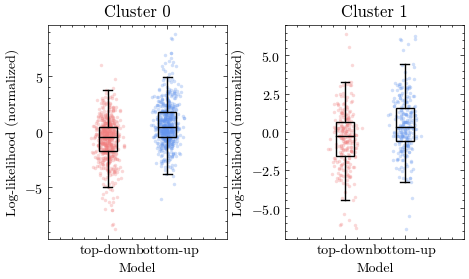

In [313]:
llh_mean = (best_llh_all_top_down + best_llh_all_bottom_up) / 2
clusters = [0, 1]
plt.figure(figsize=(5,3))
for this_cluster in clusters:
    plt.subplot(1,len(clusters),this_cluster+1)
    inds = meta_data['Cluster']==this_cluster
    this_llh_mean = llh_mean[inds]
    noise = np.random.normal(0, 0.1, np.sum(inds))
    m1_fit_metric = (best_llh_all_top_down[inds] - this_llh_mean)
    m2_fit_metric = (best_llh_all_bottom_up[inds] - this_llh_mean)
    plt.plot(np.ones(np.sum(inds))+noise, m1_fit_metric, '.', mew=0, ms=5, color='lightcoral', alpha=0.3)
    plt.plot(np.ones(np.sum(inds))*2+noise, m2_fit_metric, '.', mew=0, ms=5, color='cornflowerblue', alpha=0.3)
    plt.boxplot([m1_fit_metric, m2_fit_metric], sym='', widths=0.3, patch_artist=True, boxprops=dict(facecolor='none', color='black'), whiskerprops=dict(color='black'), medianprops=dict(color='black'), capprops=dict(color='black'))
    plt.xlim(0,3)
    plt.xlabel('Model')
    plt.ylabel('Log-likelihood (normalized)')
    plt.xticks([1,2], ['top-down', 'bottom-up'])
    plt.title('Cluster '+str(this_cluster))
plt.tight_layout()
plt.show()

### All (first 6 blocks)

In [314]:
subject_inds = (meta_data['Cluster'] == cluster)

if __name__ == "__main__":
    inputs = []
    inputs_2 = []
    for i in range(best_params_all_bottom_up[subject_inds].shape[0]):
        alpha_2, beta_2, concentration_2, epsilon, prior = best_params_all_bottom_up_no_meta[subject_inds][i,:]
        inputs.append((this_model, i, niters_sim, 1, alpha_2, 10, beta_2, 10, concentration_2, epsilon, prior, 'V1-V1', 'bottom_up', False))
        alpha_2, beta_2, concentration_2, epsilon, prior = best_params_all_bottom_up[subject_inds][i,:]
        inputs_2.append((this_model, i, niters_sim, 1, alpha_2, 10, beta_2, 10, concentration_2, epsilon, prior, 'V1-V1', 'bottom_up', True))
        
    with Pool() as p:
        results = p.map(modeling.parallel_simulator, inputs)

    data_sim_top_down_no_meta = {}
    for _, this_data in results:
        data_sim_top_down_no_meta = helpers.concatenate_data(this_data, data_sim_top_down_no_meta)

    with Pool() as p:
        results = p.map(modeling.parallel_simulator, inputs_2)

    data_sim_top_down = {}
    for _, this_data in results:
        data_sim_top_down = helpers.concatenate_data(this_data, data_sim_top_down)

/home/exouser/Desktop/jingjing/learning_hierarchy/helpers.py:918: RuntimeWarning: Mean of empty slice
  mean_population_counter1 = np.hstack((mean_population_counter1_12, np.nanmean(data_counter1[:,:,start_trial:int(start_trial+trials_to_probe)],axis=2)))
/home/exouser/Desktop/jingjing/learning_hierarchy/helpers.py:919: RuntimeWarning: Mean of empty slice
  mean_population_counter2 = np.hstack((mean_population_counter2_12, np.nanmean(data_counter2[:,:,start_trial:int(start_trial+trials_to_probe)],axis=2)))
/home/exouser/Desktop/jingjing/learning_hierarchy/helpers.py:913: RuntimeWarning: Mean of empty slice
  mean_population_counter1_12[sub,0] = np.nanmean(data_counter12_12[sub,0,0,start_trial:int(start_trial+trials_to_probe)])


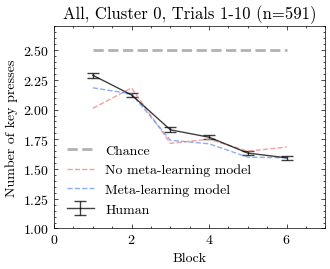

In [315]:
this_data = helpers.slice_data(all_data, meta_data, 'All', exp=[1,2], cluster=cluster)
plotting.plot_validation_n_presses(this_data, data_sim_top_down_no_meta, data_sim_top_down, 'All', cluster, nblocks=6, m1='No meta-learning', m2='Meta-learning')

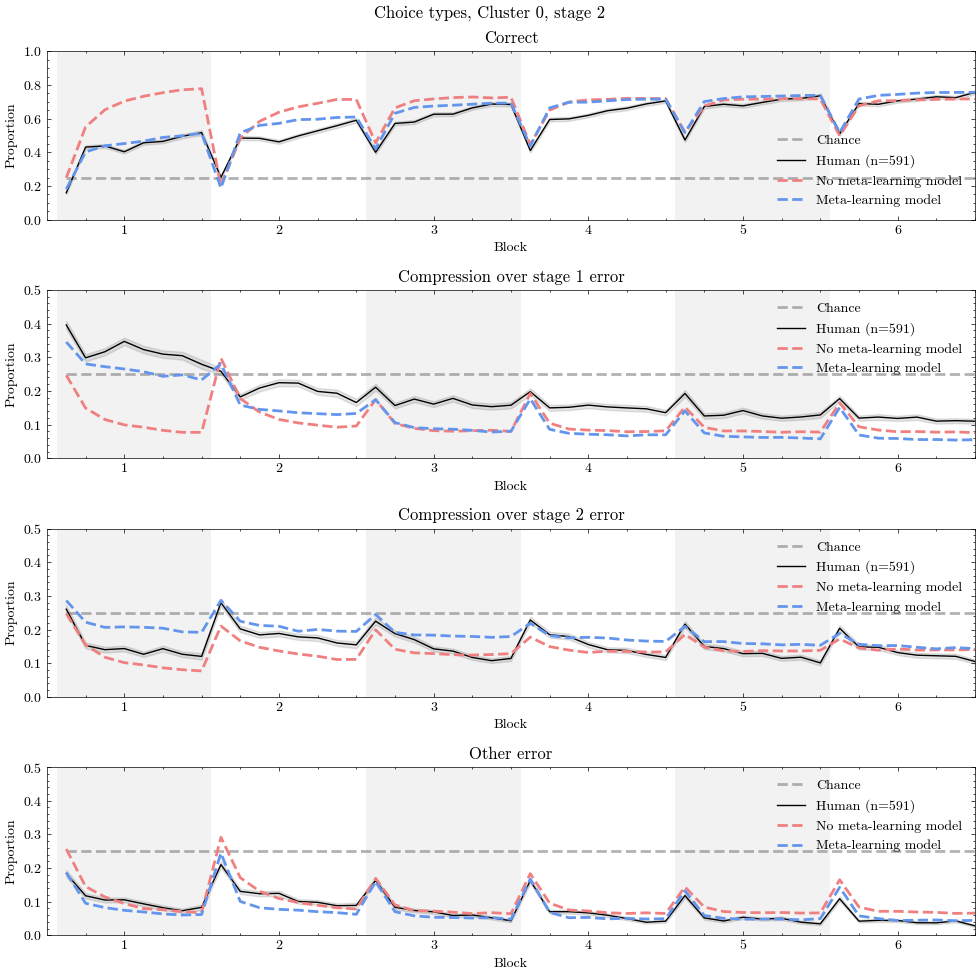

In [316]:
plotting.plot_validation_error_types(this_data, data_sim_top_down_no_meta, data_sim_top_down, 'All', cluster, nblocks=6, m1='No meta-learning', m2='Meta-learning')

### V1-V1

In [317]:
condition = 'V1-V1'
subject_inds = (meta_data['Condition'] == condition) & (meta_data['Cluster'] == cluster)

if __name__ == "__main__":
    inputs = []
    inputs_2 = []
    for i in range(best_params_all_top_down[subject_inds].shape[0]):
        alpha_2, beta_2, concentration_2, epsilon, prior = best_params_all_top_down[subject_inds][i,:]
        inputs.append((this_model, i, niters_sim, 1, alpha_2, 10, beta_2, 10, concentration_2, epsilon, prior, condition, 'top_down', True))
        alpha_2, beta_2, concentration_2, epsilon, prior = best_params_all_bottom_up[subject_inds][i,:]
        inputs_2.append((this_model, i, niters_sim, 1, alpha_2, 10, beta_2, 10, concentration_2, epsilon, prior, condition, 'bottom_up', True))
        
    with Pool() as p:
        results = p.map(modeling.parallel_simulator, inputs)

    data_sim_top_down = {}
    for _, this_data in results:
        data_sim_top_down = helpers.concatenate_data(this_data, data_sim_top_down)

    with Pool() as p:
        results = p.map(modeling.parallel_simulator, inputs_2)

    data_sim_bottom_up = {}
    for _, this_data in results:
        data_sim_bottom_up = helpers.concatenate_data(this_data, data_sim_bottom_up)

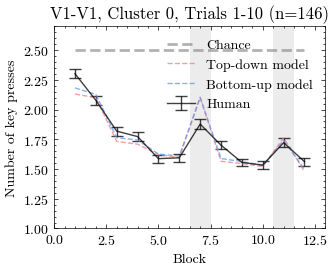

In [318]:
this_data = helpers.slice_data(all_data, meta_data, condition, exp=[1,2], cluster=cluster)
plotting.plot_validation_n_presses(this_data, data_sim_top_down, data_sim_bottom_up, condition, cluster)

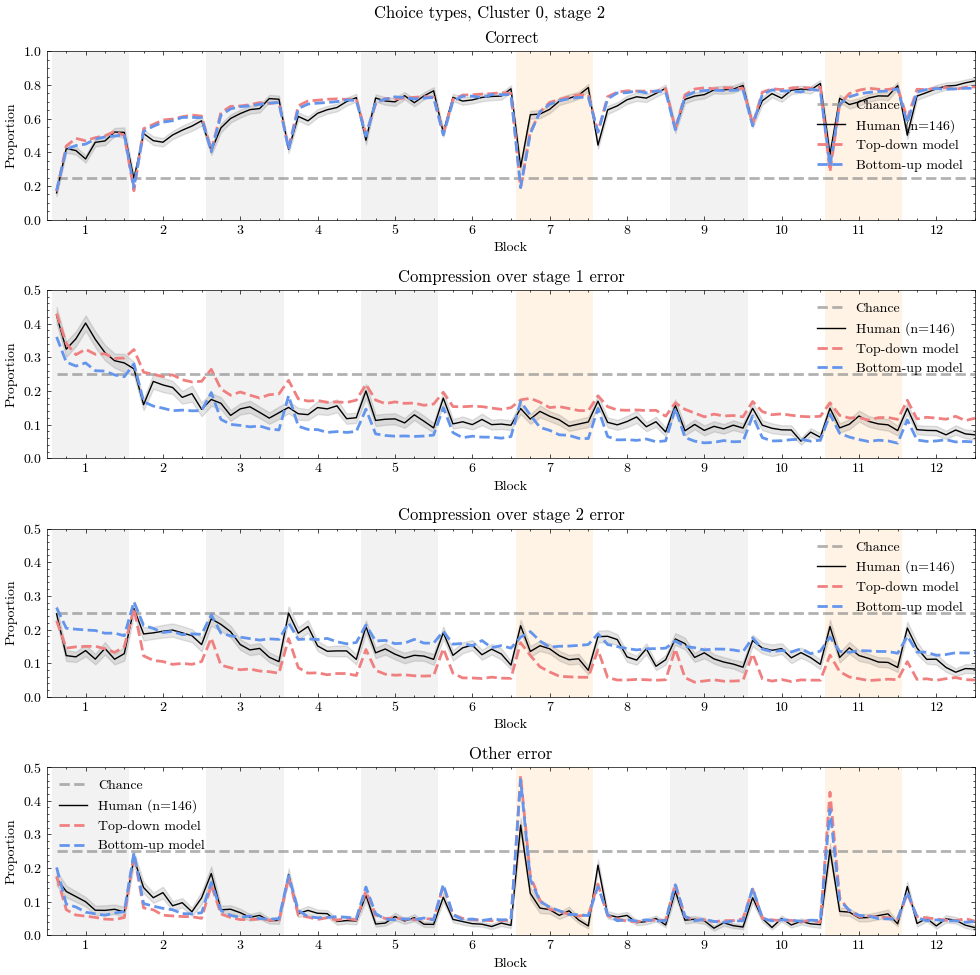

In [319]:
this_data = helpers.slice_data(all_data, meta_data, condition, exp=[1,2], cluster=cluster)
plotting.plot_validation_error_types(this_data, data_sim_top_down, data_sim_bottom_up, condition, cluster)

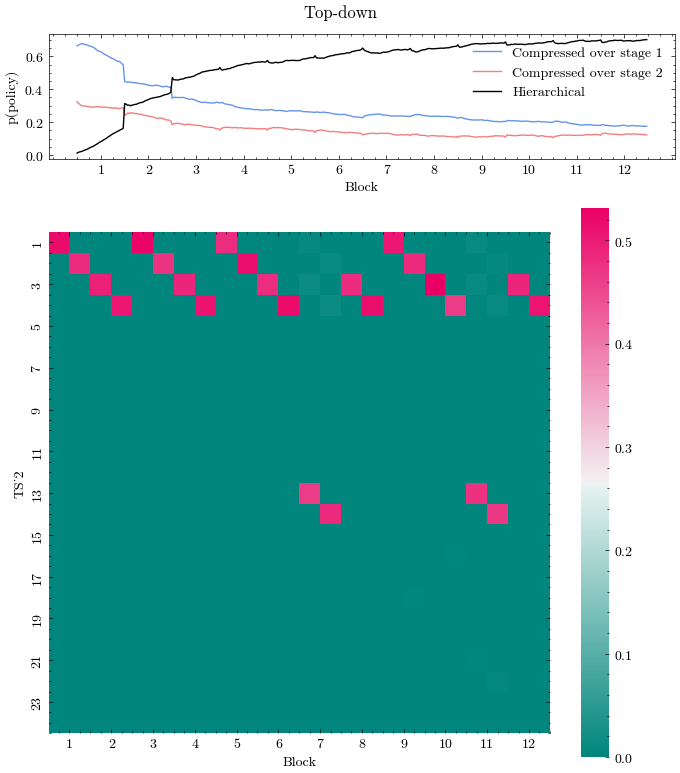

In [320]:
plotting.plot_validation_PTS(data_sim_top_down, 'Top-down', ntrials=1)

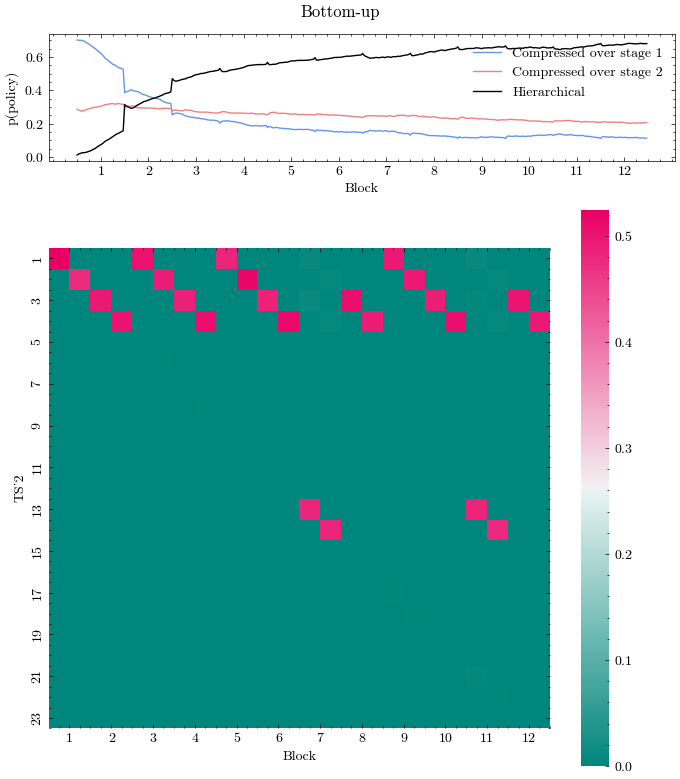

In [321]:
plotting.plot_validation_PTS(data_sim_bottom_up, 'Bottom-up', ntrials=1)

### V2-V2

In [322]:
condition = 'V2-V2'
subject_inds = (meta_data['Condition'] == condition) & (meta_data['Cluster'] == cluster)

if __name__ == "__main__":
    inputs = []
    inputs_2 = []
    for i in range(best_params_all_top_down[subject_inds].shape[0]):
        alpha_2, beta_2, concentration_2, epsilon, prior = best_params_all_top_down[subject_inds][i,:]
        inputs.append((this_model, i, niters_sim, 1, alpha_2, 10, beta_2, 10, concentration_2, epsilon, prior, condition, 'top_down', True))
        alpha_2, beta_2, concentration_2, epsilon, prior = best_params_all_bottom_up[subject_inds][i,:]
        inputs_2.append((this_model, i, niters_sim, 1, alpha_2, 10, beta_2, 10, concentration_2, epsilon, prior, condition, 'bottom_up', True))
        
    with Pool() as p:
        results = p.map(modeling.parallel_simulator, inputs)

    data_sim_top_down = {}
    for _, this_data in results:
        data_sim_top_down = helpers.concatenate_data(this_data, data_sim_top_down)

    with Pool() as p:
        results = p.map(modeling.parallel_simulator, inputs_2)

    data_sim_bottom_up = {}
    for _, this_data in results:
        data_sim_bottom_up = helpers.concatenate_data(this_data, data_sim_bottom_up)

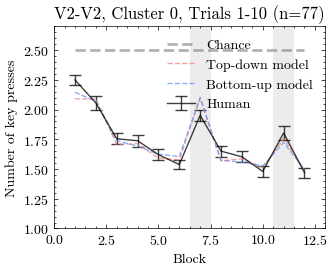

In [323]:
this_data = helpers.slice_data(all_data, meta_data, condition, exp=[1,2], cluster=cluster)
plotting.plot_validation_n_presses(this_data, data_sim_top_down, data_sim_bottom_up, condition, cluster)

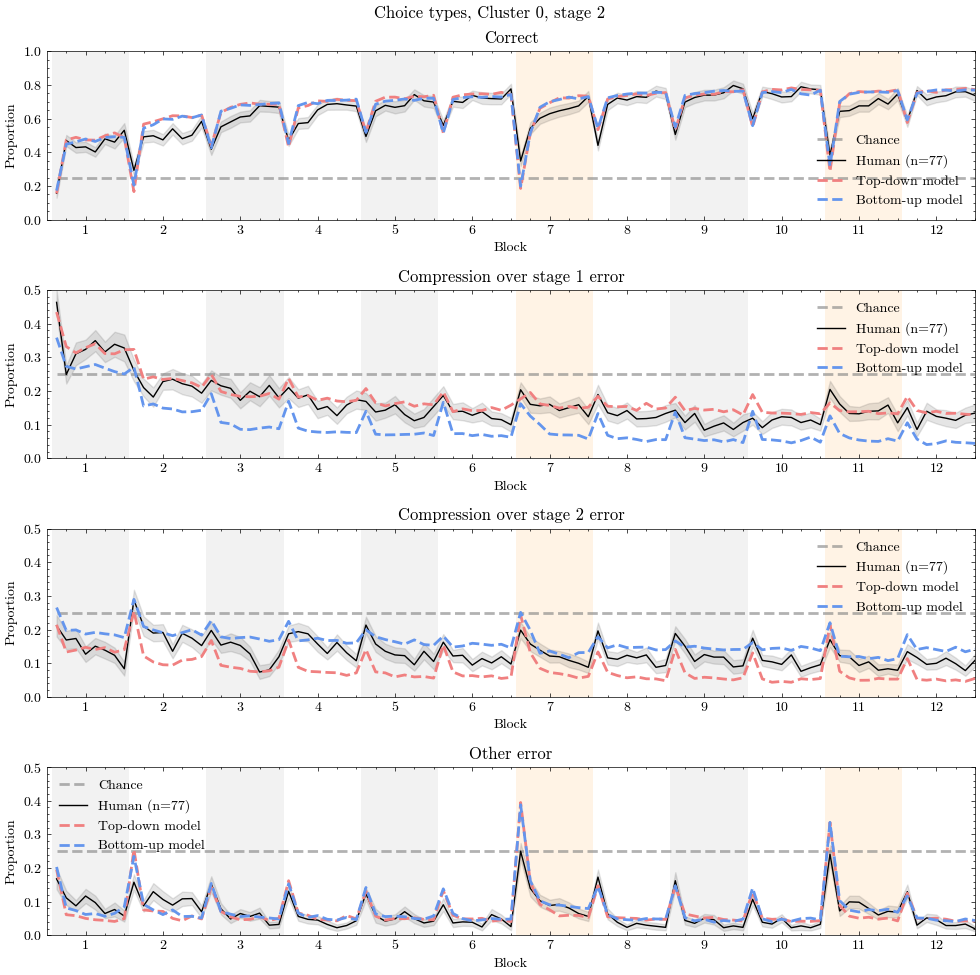

In [324]:
this_data = helpers.slice_data(all_data, meta_data, condition, exp=[1,2], cluster=cluster)
plotting.plot_validation_error_types(this_data, data_sim_top_down, data_sim_bottom_up, condition, cluster)

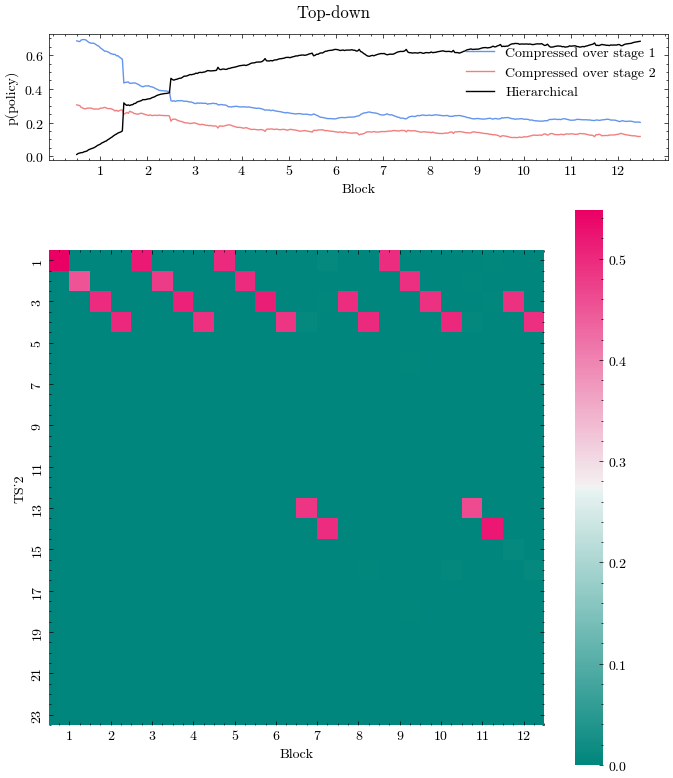

In [325]:
plotting.plot_validation_PTS(data_sim_top_down, 'Top-down', ntrials=1)

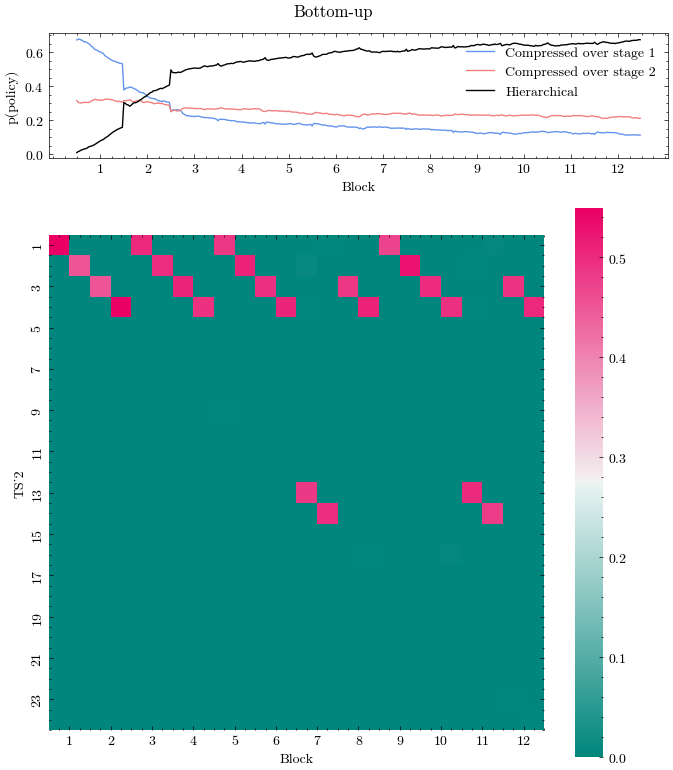

In [326]:
plotting.plot_validation_PTS(data_sim_bottom_up, 'Bottom-up', ntrials=1)

### V3-V3

In [327]:
condition = 'V3-V3'
subject_inds = (meta_data['Condition'] == condition) & (meta_data['Cluster'] == cluster)

if __name__ == "__main__":
    inputs = []
    inputs_2 = []
    for i in range(best_params_all_top_down[subject_inds].shape[0]):
        alpha_2, beta_2, concentration_2, epsilon, prior = best_params_all_top_down[subject_inds][i,:]
        inputs.append((this_model, i, niters_sim, 1, alpha_2, 10, beta_2, 10, concentration_2, epsilon, prior, condition, 'top_down', True))
        alpha_2, beta_2, concentration_2, epsilon, prior = best_params_all_bottom_up[subject_inds][i,:]
        inputs_2.append((this_model, i, niters_sim, 1, alpha_2, 10, beta_2, 10, concentration_2, epsilon, prior, condition, 'bottom_up', True))
        
    with Pool() as p:
        results = p.map(modeling.parallel_simulator, inputs)

    data_sim_top_down = {}
    for _, this_data in results:
        data_sim_top_down = helpers.concatenate_data(this_data, data_sim_top_down)

    with Pool() as p:
        results = p.map(modeling.parallel_simulator, inputs_2)

    data_sim_bottom_up = {}
    for _, this_data in results:
        data_sim_bottom_up = helpers.concatenate_data(this_data, data_sim_bottom_up)

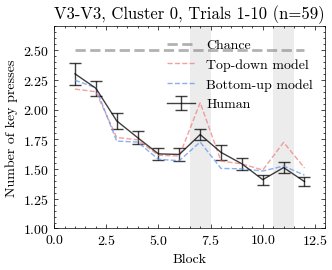

In [328]:
this_data = helpers.slice_data(all_data, meta_data, condition, exp=[1,2], cluster=cluster)
plotting.plot_validation_n_presses(this_data, data_sim_top_down, data_sim_bottom_up, condition, cluster)

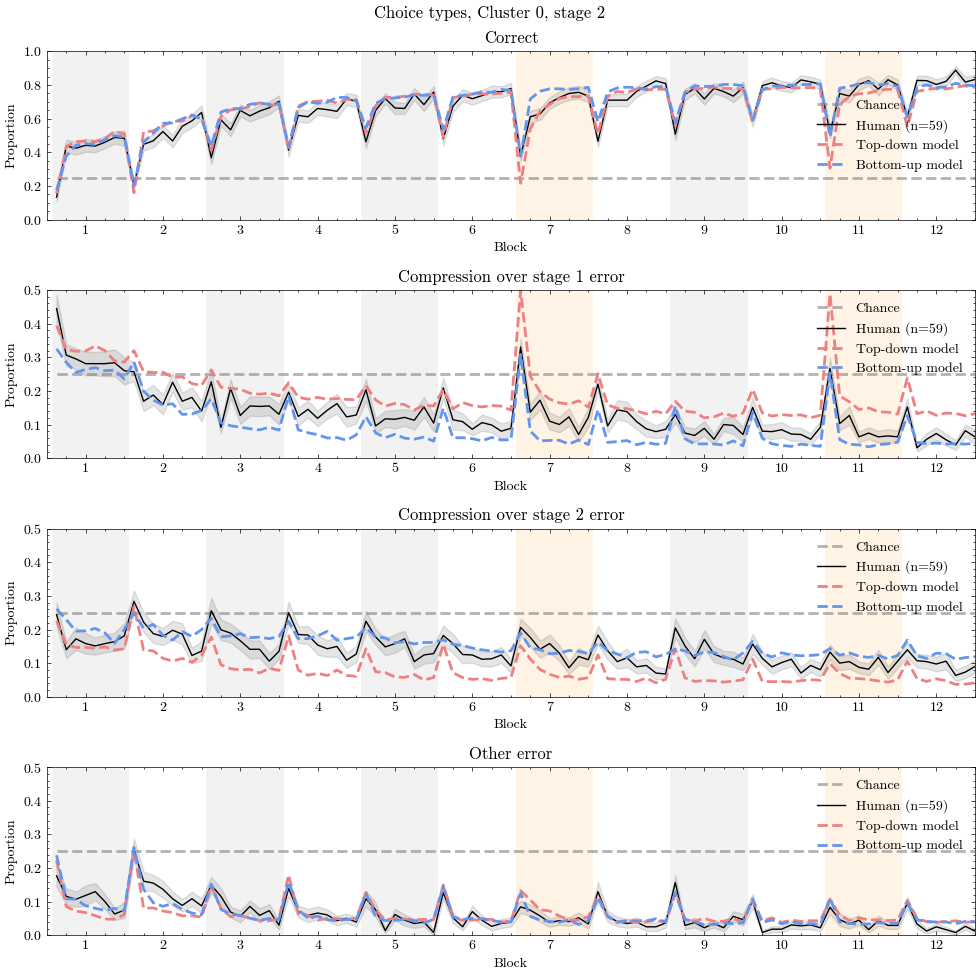

In [329]:
this_data = helpers.slice_data(all_data, meta_data, condition, exp=[1,2], cluster=cluster)
plotting.plot_validation_error_types(this_data, data_sim_top_down, data_sim_bottom_up, condition, cluster)

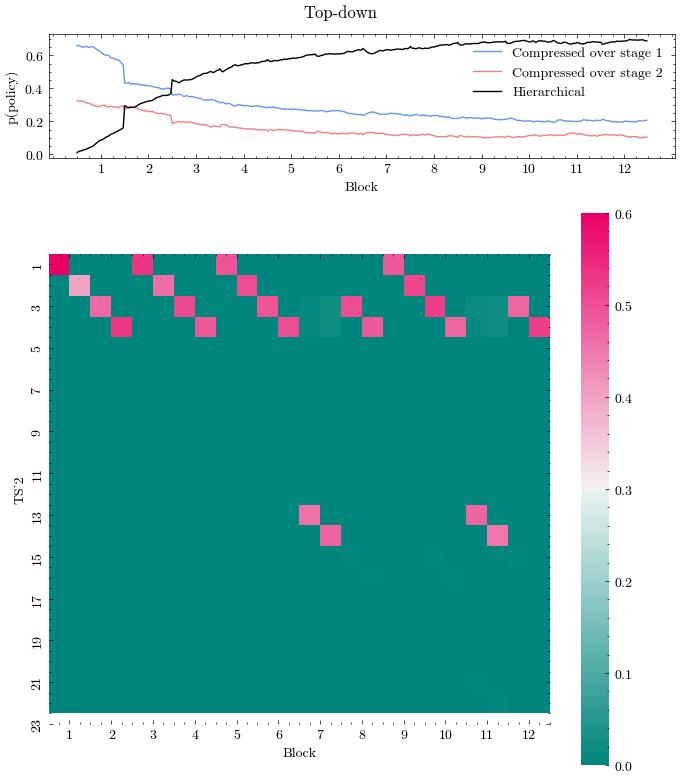

In [330]:
plotting.plot_validation_PTS(data_sim_top_down, 'Top-down', ntrials=1)

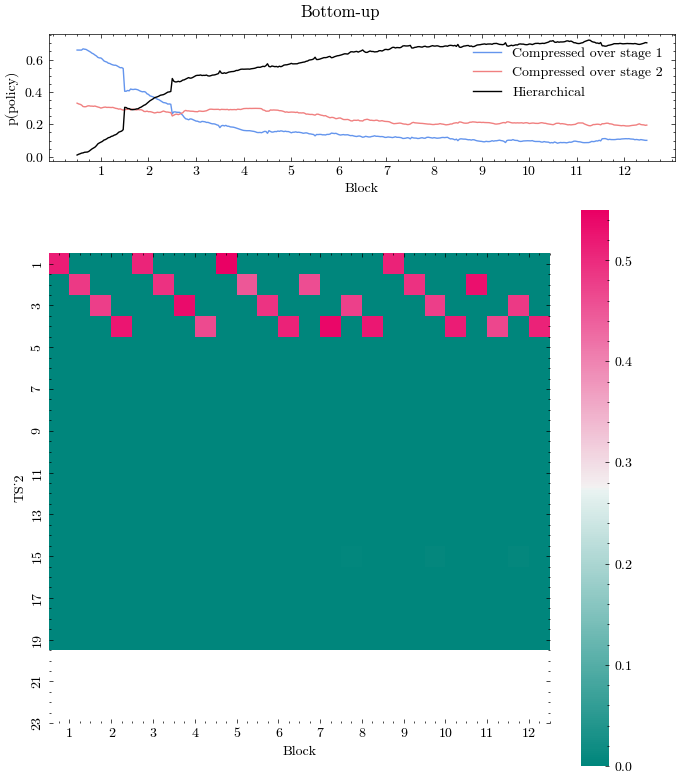

In [331]:
plotting.plot_validation_PTS(data_sim_bottom_up, 'Bottom-up', ntrials=1)

### V1-V2

In [332]:
condition = 'V1-V2'
subject_inds = (meta_data['Condition'] == condition) & (meta_data['Cluster'] == cluster)

if __name__ == "__main__":
    inputs = []
    inputs_2 = []
    for i in range(best_params_all_top_down[subject_inds].shape[0]):
        alpha_2, beta_2, concentration_2, epsilon, prior = best_params_all_top_down[subject_inds][i,:]
        inputs.append((this_model, i, niters_sim, 1, alpha_2, 10, beta_2, 10, concentration_2, epsilon, prior, condition, 'top_down', True))
        alpha_2, beta_2, concentration_2, epsilon, prior = best_params_all_bottom_up[subject_inds][i,:]
        inputs_2.append((this_model, i, niters_sim, 1, alpha_2, 10, beta_2, 10, concentration_2, epsilon, prior, condition, 'bottom_up', True))
        
    with Pool() as p:
        results = p.map(modeling.parallel_simulator, inputs)

    data_sim_top_down = {}
    for _, this_data in results:
        data_sim_top_down = helpers.concatenate_data(this_data, data_sim_top_down)

    with Pool() as p:
        results = p.map(modeling.parallel_simulator, inputs_2)

    data_sim_bottom_up = {}
    for _, this_data in results:
        data_sim_bottom_up = helpers.concatenate_data(this_data, data_sim_bottom_up)

/home/exouser/Desktop/jingjing/learning_hierarchy/helpers.py:918: RuntimeWarning: Mean of empty slice
  mean_population_counter1 = np.hstack((mean_population_counter1_12, np.nanmean(data_counter1[:,:,start_trial:int(start_trial+trials_to_probe)],axis=2)))
/home/exouser/Desktop/jingjing/learning_hierarchy/helpers.py:919: RuntimeWarning: Mean of empty slice
  mean_population_counter2 = np.hstack((mean_population_counter2_12, np.nanmean(data_counter2[:,:,start_trial:int(start_trial+trials_to_probe)],axis=2)))


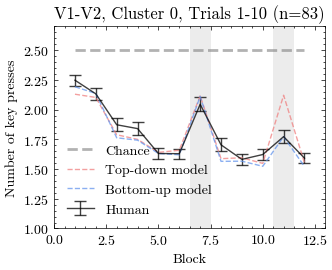

In [333]:
this_data = helpers.slice_data(all_data, meta_data, condition, exp=[1,2], cluster=cluster)
plotting.plot_validation_n_presses(this_data, data_sim_top_down, data_sim_bottom_up, condition, cluster)

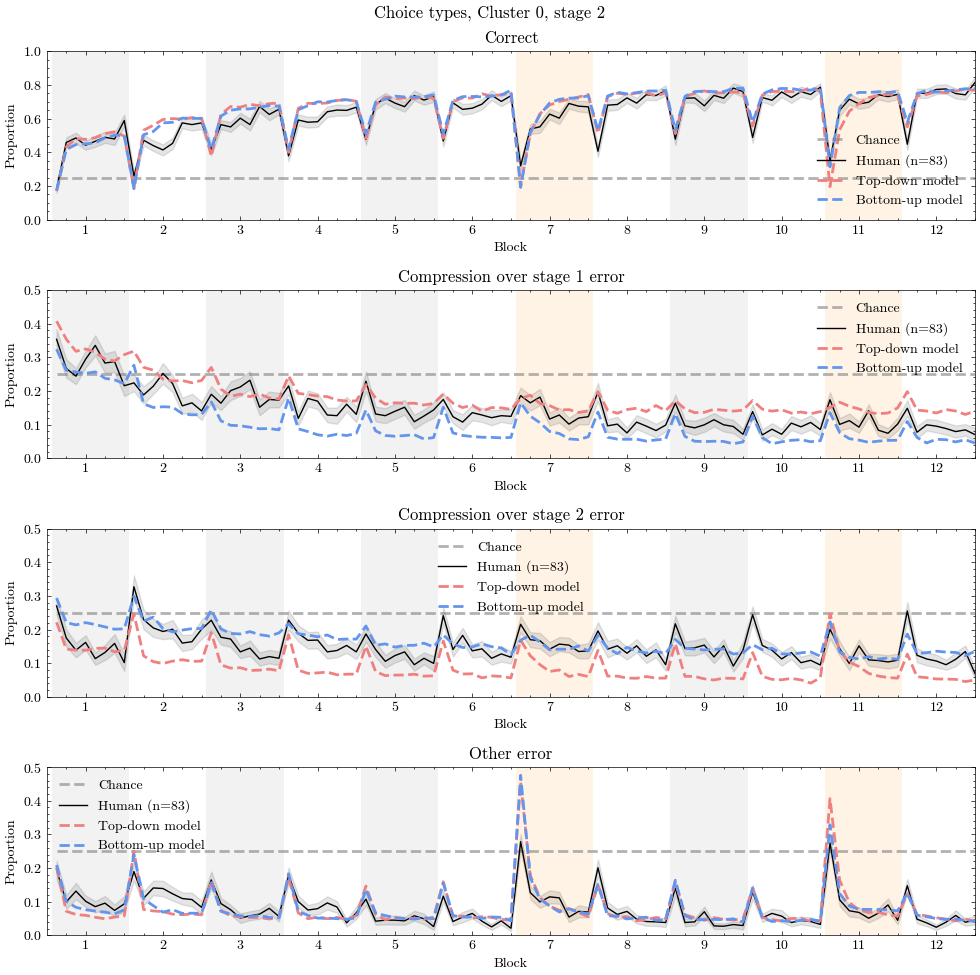

In [334]:
this_data = helpers.slice_data(all_data, meta_data, condition, exp=[1,2], cluster=cluster)
plotting.plot_validation_error_types(this_data, data_sim_top_down, data_sim_bottom_up, condition, cluster)

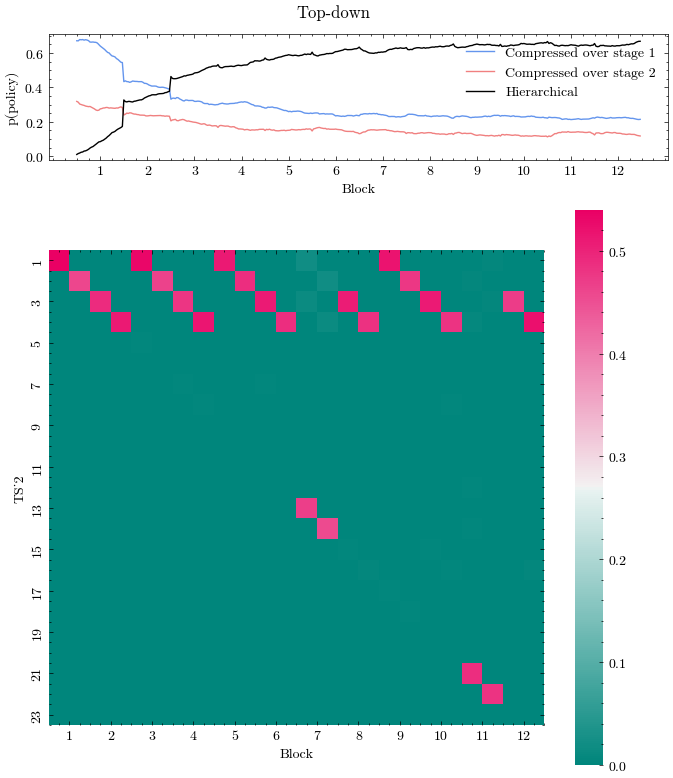

In [335]:
plotting.plot_validation_PTS(data_sim_top_down, 'Top-down', ntrials=1)

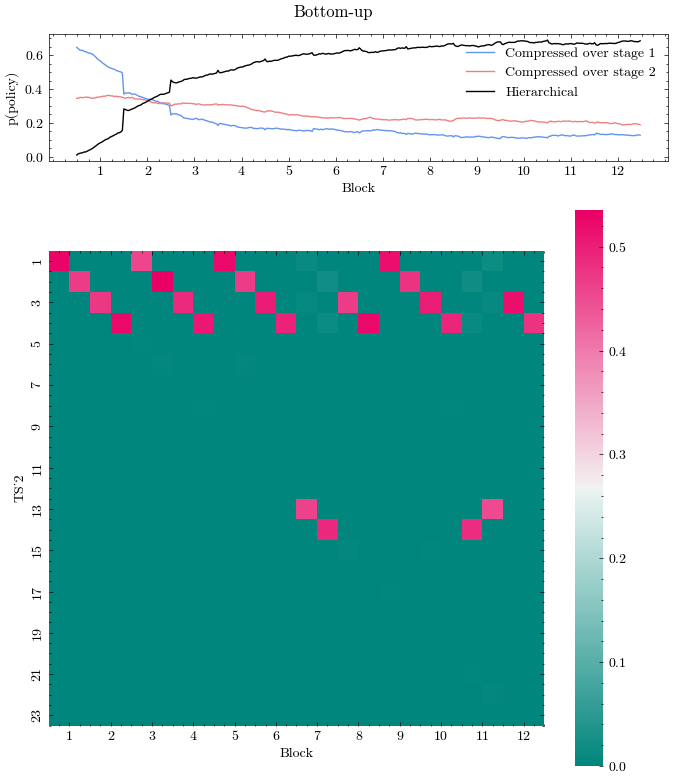

In [336]:
plotting.plot_validation_PTS(data_sim_bottom_up, 'Bottom-up', ntrials=1)

### V2-V1

In [337]:
condition = 'V2-V1'
subject_inds = (meta_data['Condition'] == condition) & (meta_data['Cluster'] == cluster)

if __name__ == "__main__":
    inputs = []
    inputs_2 = []
    for i in range(best_params_all_top_down[subject_inds].shape[0]):
        alpha_2, beta_2, concentration_2, epsilon, prior = best_params_all_top_down[subject_inds][i,:]
        inputs.append((this_model, i, niters_sim, 1, alpha_2, 10, beta_2, 10, concentration_2, epsilon, prior, condition, 'top_down', True))
        alpha_2, beta_2, concentration_2, epsilon, prior = best_params_all_bottom_up[subject_inds][i,:]
        inputs_2.append((this_model, i, niters_sim, 1, alpha_2, 10, beta_2, 10, concentration_2, epsilon, prior, condition, 'bottom_up', True))
        
    with Pool() as p:
        results = p.map(modeling.parallel_simulator, inputs)

    data_sim_top_down = {}
    for _, this_data in results:
        data_sim_top_down = helpers.concatenate_data(this_data, data_sim_top_down)

    with Pool() as p:
        results = p.map(modeling.parallel_simulator, inputs_2)

    data_sim_bottom_up = {}
    for _, this_data in results:
        data_sim_bottom_up = helpers.concatenate_data(this_data, data_sim_bottom_up)

/home/exouser/Desktop/jingjing/learning_hierarchy/helpers.py:918: RuntimeWarning: Mean of empty slice
  mean_population_counter1 = np.hstack((mean_population_counter1_12, np.nanmean(data_counter1[:,:,start_trial:int(start_trial+trials_to_probe)],axis=2)))
/home/exouser/Desktop/jingjing/learning_hierarchy/helpers.py:913: RuntimeWarning: Mean of empty slice
  mean_population_counter1_12[sub,0] = np.nanmean(data_counter12_12[sub,0,0,start_trial:int(start_trial+trials_to_probe)])


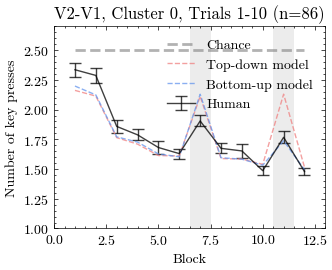

In [338]:
this_data = helpers.slice_data(all_data, meta_data, condition, exp=[1,2], cluster=cluster)
plotting.plot_validation_n_presses(this_data, data_sim_top_down, data_sim_bottom_up, condition, cluster)

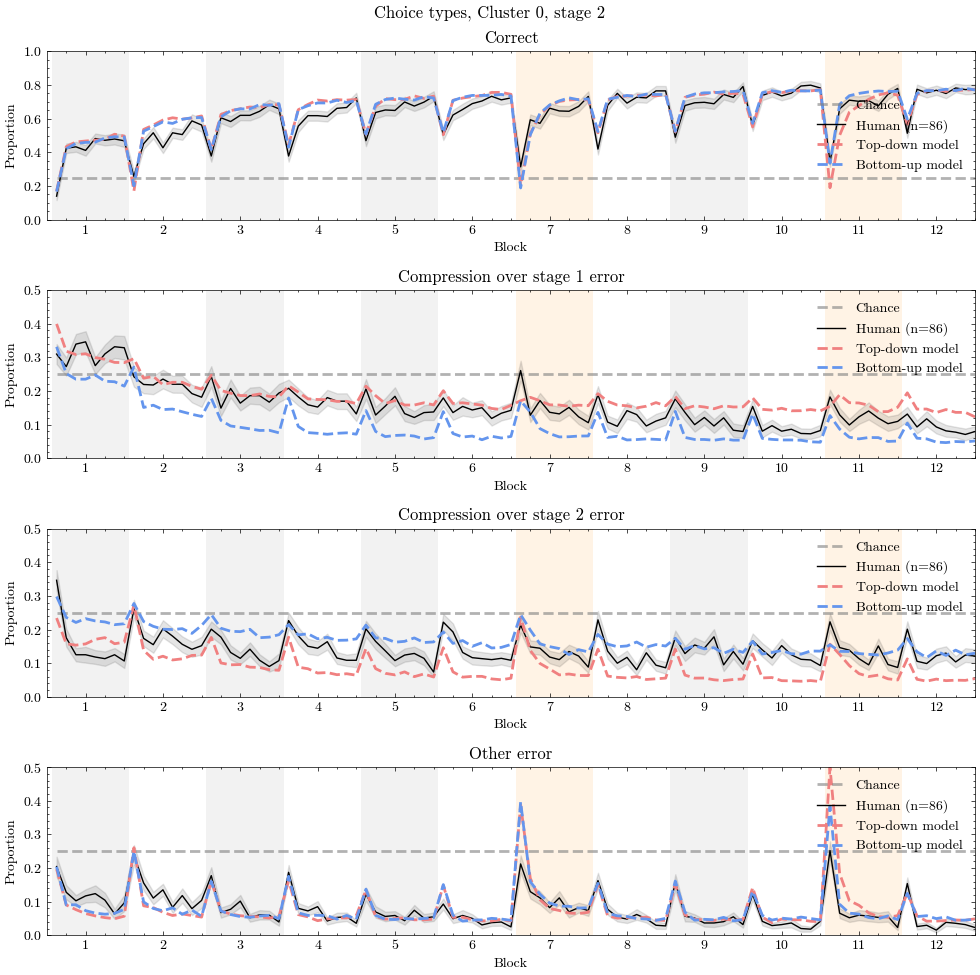

In [339]:
this_data = helpers.slice_data(all_data, meta_data, condition, exp=[1,2], cluster=cluster)
plotting.plot_validation_error_types(this_data, data_sim_top_down, data_sim_bottom_up, condition, cluster)

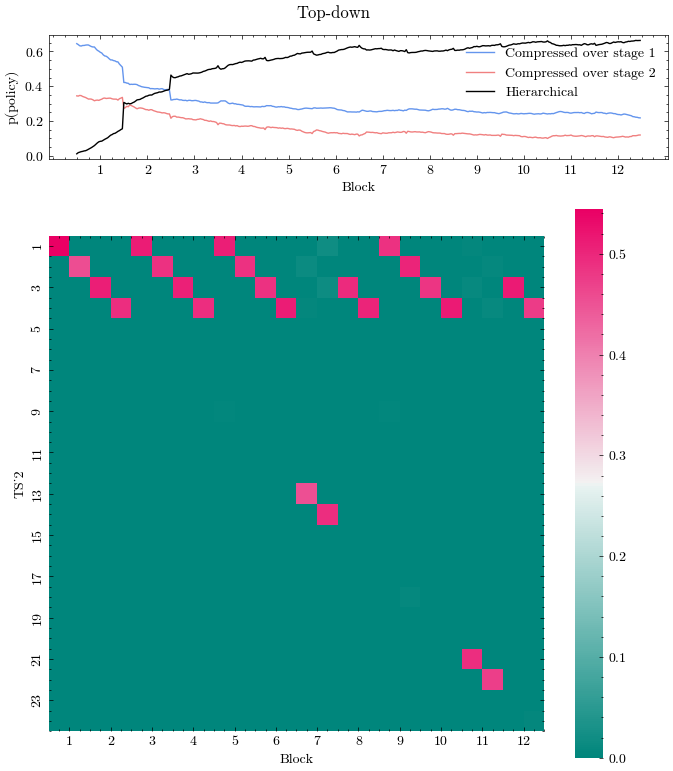

In [340]:
plotting.plot_validation_PTS(data_sim_top_down, 'Top-down', ntrials=1)

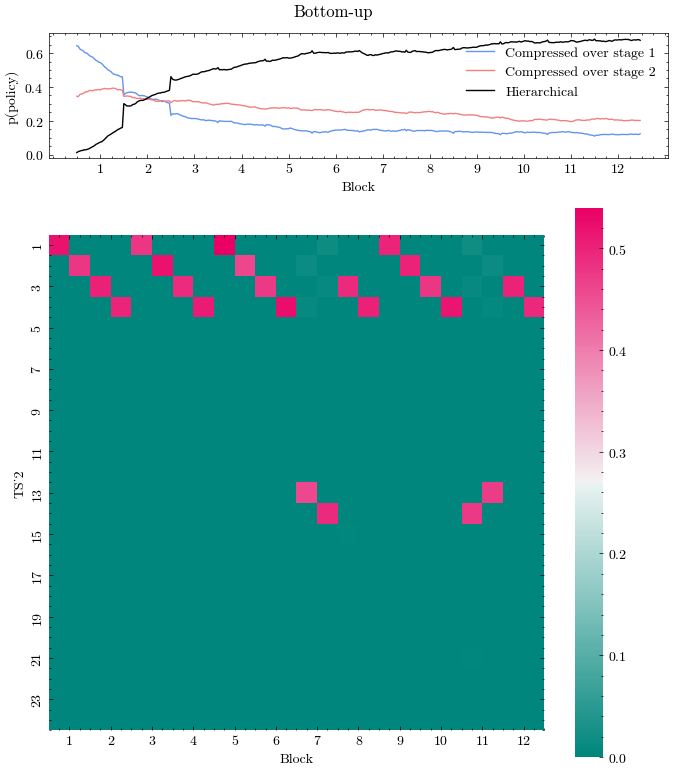

In [341]:
plotting.plot_validation_PTS(data_sim_bottom_up, 'Bottom-up', ntrials=1)

### V1-V3

In [342]:
condition = 'V1-V3'
subject_inds = (meta_data['Condition'] == condition) & (meta_data['Cluster'] == cluster)

if __name__ == "__main__":
    inputs = []
    inputs_2 = []
    for i in range(best_params_all_top_down[subject_inds].shape[0]):
        alpha_2, beta_2, concentration_2, epsilon, prior = best_params_all_top_down[subject_inds][i,:]
        inputs.append((this_model, i, niters_sim, 1, alpha_2, 10, beta_2, 10, concentration_2, epsilon, prior, condition, 'top_down', True))
        alpha_2, beta_2, concentration_2, epsilon, prior = best_params_all_bottom_up[subject_inds][i,:]
        inputs_2.append((this_model, i, niters_sim, 1, alpha_2, 10, beta_2, 10, concentration_2, epsilon, prior, condition, 'bottom_up', True))
        
    with Pool() as p:
        results = p.map(modeling.parallel_simulator, inputs)

    data_sim_top_down = {}
    for _, this_data in results:
        data_sim_top_down = helpers.concatenate_data(this_data, data_sim_top_down)

    with Pool() as p:
        results = p.map(modeling.parallel_simulator, inputs_2)

    data_sim_bottom_up = {}
    for _, this_data in results:
        data_sim_bottom_up = helpers.concatenate_data(this_data, data_sim_bottom_up)

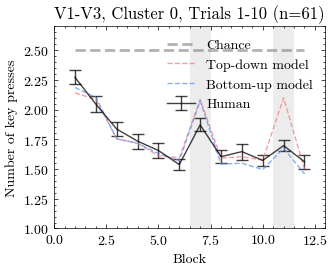

In [343]:
this_data = helpers.slice_data(all_data, meta_data, condition, exp=[1,2], cluster=cluster)
plotting.plot_validation_n_presses(this_data, data_sim_top_down, data_sim_bottom_up, condition, cluster)

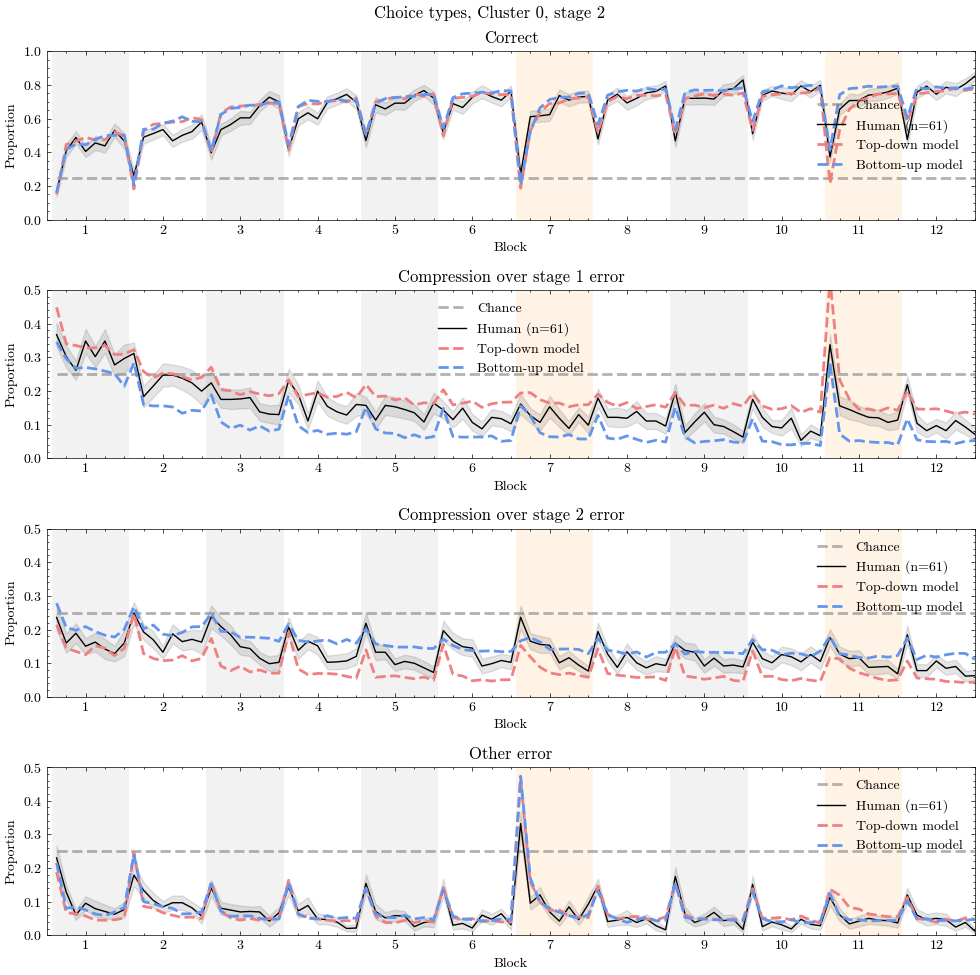

In [344]:
this_data = helpers.slice_data(all_data, meta_data, condition, exp=[1,2], cluster=cluster)
plotting.plot_validation_error_types(this_data, data_sim_top_down, data_sim_bottom_up, condition, cluster)

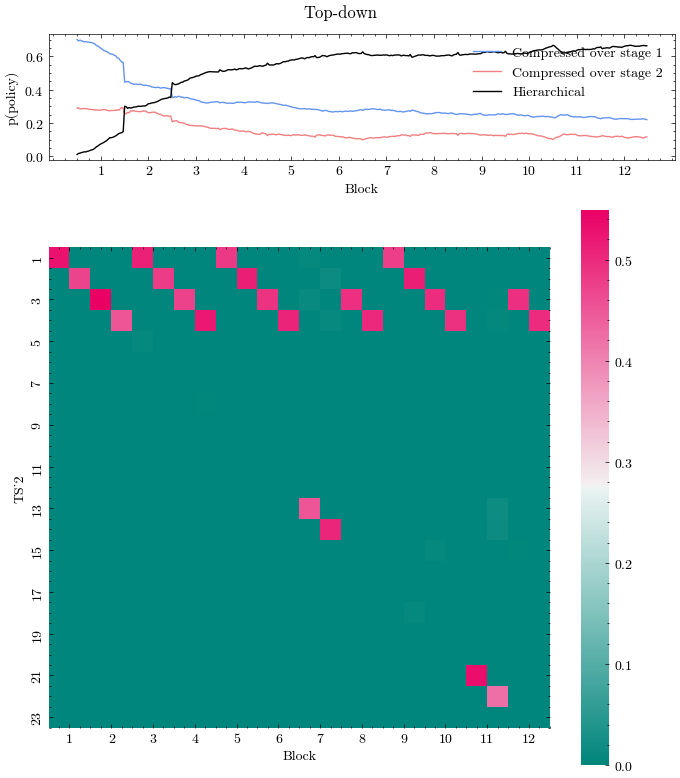

In [345]:
plotting.plot_validation_PTS(data_sim_top_down, 'Top-down', ntrials=1)

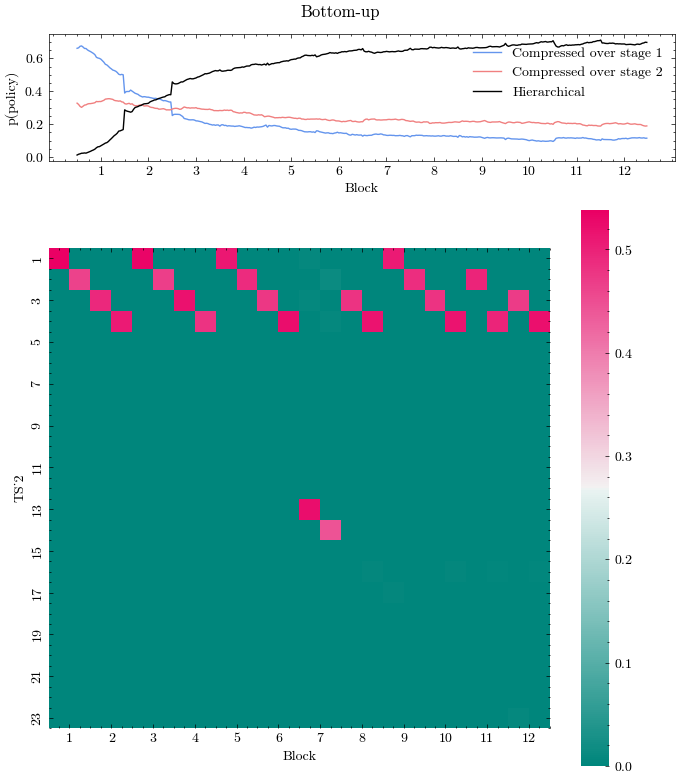

In [346]:
plotting.plot_validation_PTS(data_sim_bottom_up, 'Bottom-up', ntrials=1)

### V3-V1

In [362]:
condition = 'V3-V1'
subject_inds = (meta_data['Condition'] == condition) & (meta_data['Cluster'] == cluster)

if __name__ == "__main__":
    inputs = []
    inputs_2 = []
    for i in range(best_params_all_top_down[subject_inds].shape[0]):
        alpha_2, beta_2, concentration_2, epsilon, prior = best_params_all_top_down[subject_inds][i,:]
        inputs.append((this_model, i, niters_sim, 1, alpha_2, 10, beta_2, 10, concentration_2, epsilon, prior, condition, 'top_down', True))
        alpha_2, beta_2, concentration_2, epsilon, prior = best_params_all_bottom_up[subject_inds][i,:]
        inputs_2.append((this_model, i, niters_sim, 1, alpha_2, 10, beta_2, 10, concentration_2, epsilon, prior, condition, 'bottom_up', True))
        
    with Pool() as p:
        results = p.map(modeling.parallel_simulator, inputs)

    data_sim_top_down = {}
    for _, this_data in results:
        data_sim_top_down = helpers.concatenate_data(this_data, data_sim_top_down)

    with Pool() as p:
        results = p.map(modeling.parallel_simulator, inputs_2)

    data_sim_bottom_up = {}
    for _, this_data in results:
        data_sim_bottom_up = helpers.concatenate_data(this_data, data_sim_bottom_up)

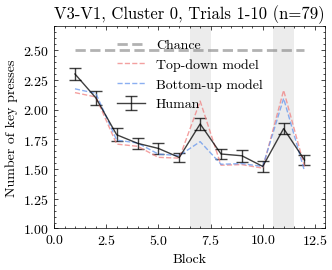

In [363]:
this_data = helpers.slice_data(all_data, meta_data, condition, exp=[1,2], cluster=cluster)
plotting.plot_validation_n_presses(this_data, data_sim_top_down, data_sim_bottom_up, condition, cluster)

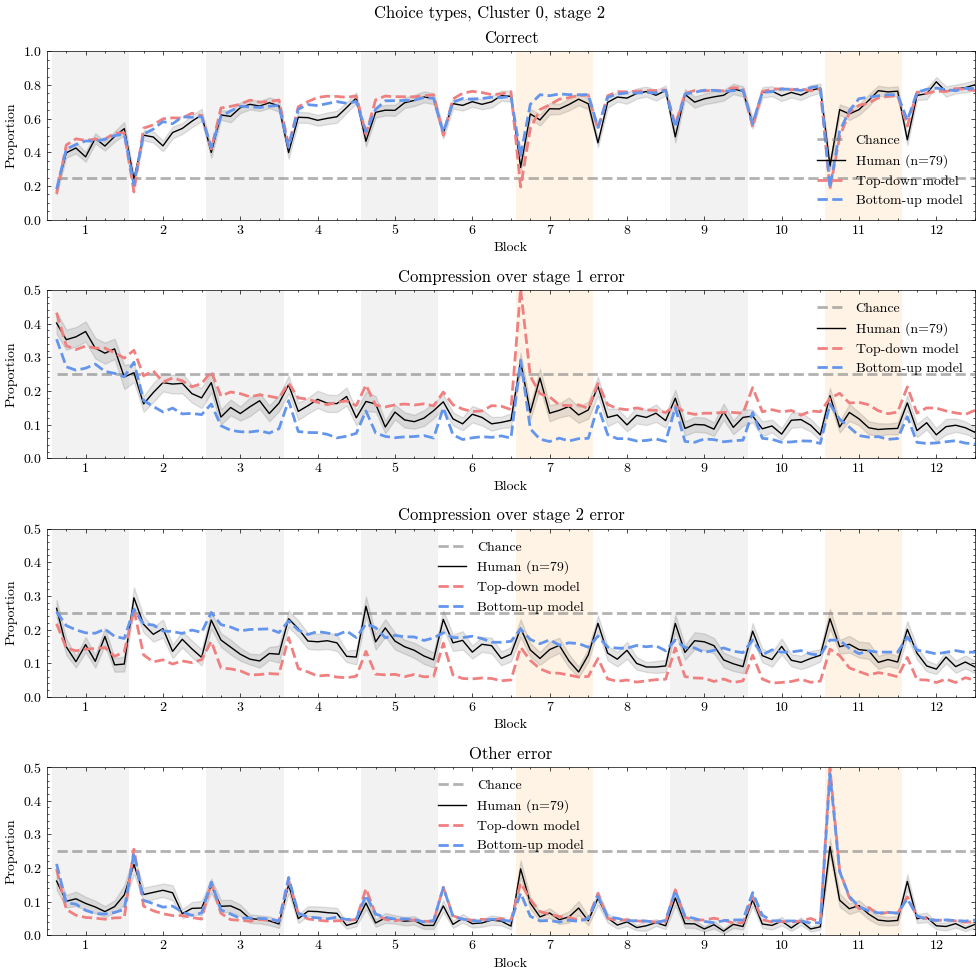

In [364]:
this_data = helpers.slice_data(all_data, meta_data, condition, exp=[1,2], cluster=cluster)
plotting.plot_validation_error_types(this_data, data_sim_top_down, data_sim_bottom_up, condition, cluster)

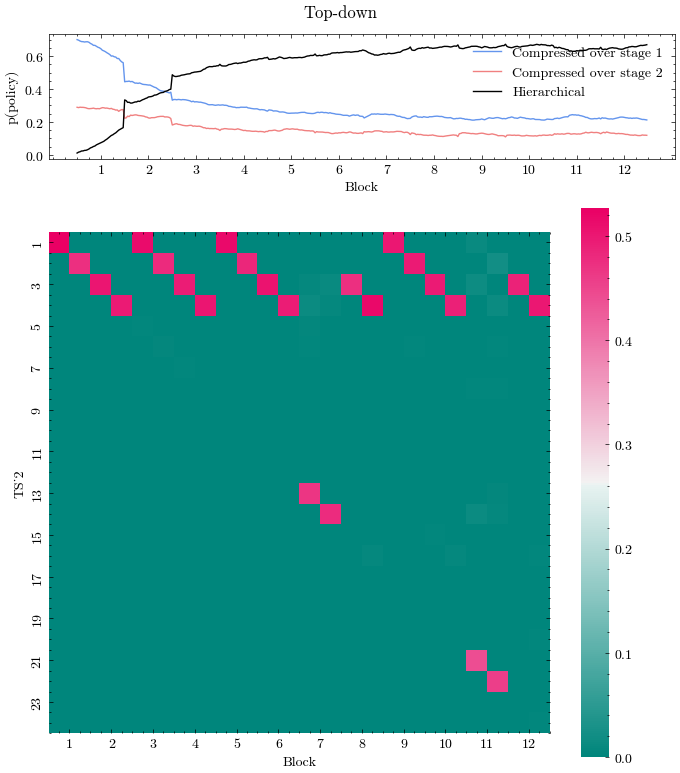

In [365]:
plotting.plot_validation_PTS(data_sim_top_down, 'Top-down', ntrials=1)

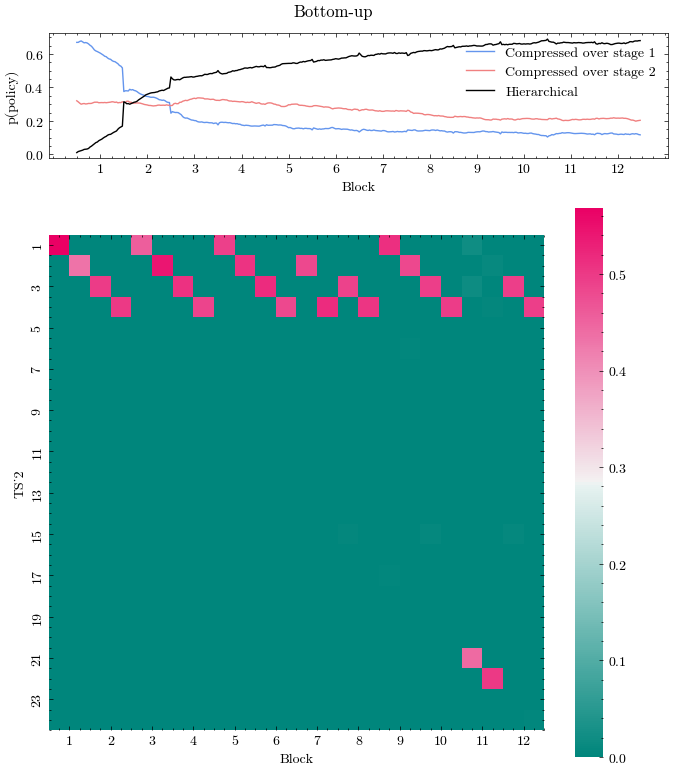

In [366]:
plotting.plot_validation_PTS(data_sim_bottom_up, 'Bottom-up', ntrials=1)